# Imports required

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

!pip install deap

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import operator
import random

import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


Loading in CIFAR-10

In [2]:
# The dataset comes in data of the range 0-1, we want to convert this to -1 to 1 as part of normalisation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Function to transform the dataset to the specified range

batch_size = 4

# Downloading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading the training set into a variable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# etc.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Specifying the classes of the dataset that we want to train the classifier on
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49047113.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Testing for GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Testing to see if we can see the images

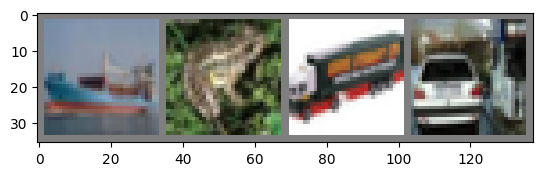

ship  frog  truck car  


In [4]:
# functions to show an image for fun


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Building network definition

In [5]:
# Relu is a fast output function

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net()

In [6]:
# Upload GD_Model.pth to the session to act as pre-defined network
from google.colab import files
files.upload()

Saving GD_Model.pth to GD_Model.pth


{'GD_Model.pth': b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x12\x00\x10\x00cifar_net/data.pklFB\x0c\x00ZZZZZZZZZZZZ\x80\x02ccollections\nOrderedDict\nq\x00)Rq\x01(X\x0c\x00\x00\x00conv1.weightq\x02ctorch._utils\n_rebuild_tensor_v2\nq\x03((X\x07\x00\x00\x00storageq\x04ctorch\nFloatStorage\nq\x05X\x01\x00\x00\x000q\x06X\x03\x00\x00\x00cpuq\x07M\xc2\x01tq\x08QK\x00(K\x06K\x03K\x05K\x05tq\t(KKK\x19K\x05K\x01tq\n\x89h\x00)Rq\x0btq\x0cRq\rX\n\x00\x00\x00conv1.biasq\x0eh\x03((h\x04h\x05X\x01\x00\x00\x001q\x0fh\x07K\x06tq\x10QK\x00K\x06\x85q\x11K\x01\x85q\x12\x89h\x00)Rq\x13tq\x14Rq\x15X\x0c\x00\x00\x00conv2.weightq\x16h\x03((h\x04h\x05X\x01\x00\x00\x002q\x17h\x07M`\ttq\x18QK\x00(K\x10K\x06K\x05K\x05tq\x19(K\x96K\x19K\x05K\x01tq\x1a\x89h\x00)Rq\x1btq\x1cRq\x1dX\n\x00\x00\x00conv2.biasq\x1eh\x03((h\x04h\x05X\x01\x00\x00\x003q\x1fh\x07K\x10tq QK\x00K\x10\x85q!K\x01\x85q"\x89h\x00)Rq#tq$Rq%X\n\x00\x00\x00fc1.weightq&h\x03((h\x04h\x05X\x01\

Loading in the model

In [7]:
PATH = ('./GD_Model.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
# Setting all layers to not change their weights with GD backpropagation

for param in PopModel.parameters():
  # By setting the requires grad for each parameter to false, we no longer track it with autograd
  # Consequently, backpropagation or whatever will not compute the gradients for these layers
  param.requires_grad = False

Getting the final layer

In [9]:
finalLayer = list(PopModel.children())[-1]

print(finalLayer) # 10 features out

print(len(finalLayer.weight)) # 10 population size


print(len(finalLayer.weight[0])) # 10 arrays, with 84 items in it

# 84 inputs connected to a single output, there are 10 outputs therefore 84x10 connections in total. for one output, the 84 connections will have 84 different weights which are used
# to calculate the output node. therefore there are 10 tensors with 84 elements in each tensor, with a different set of weights.

# print(finalLayer.weight)

#print(finalLayer.weight) # Layer requires 840 connections

print(len(finalLayer.bias))

paramCount = sum(param.numel() for param in finalLayer.parameters())

print(paramCount) # 850 Parameters: 840 weights + 10 biases

Linear(in_features=84, out_features=10, bias=True)
10
84
10
850


In [14]:
# Randomise final layer weights

nn.init.xavier_uniform(finalLayer.weight)

#print(finalLayer.weight)

print((finalLayer.weight).shape) # Shape that the layer requires is (10,84)

torch.Size([10, 84])


<ipython-input-14-0b70887f5653>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(finalLayer.weight)


In [15]:
# Converting weights to a numpy array

def convert_np_function(self, intermediate_tensor):
        intermediate_value = intermediate_tensor.numpy()
        self.intermediate_values.append(intermediate_value)

populationList = finalLayer.weight.numpy()


#print(populationList) # Converted to Numpy

Defining PSO functions

In [94]:
posMinInit      = -3
posMaxInit      = + 5
VMaxInit        = 1.5
VMinInit        = 0.5
populationSize  = 10
dimension       = 840
interval        = 10
iterations      = 400

#Parameter setup

wmax = 0.9 #weighting
wmin = 0.4
c1   = 2.0
c2   = 2.0

# Criterion for measuring loss, may need to tweak this to return negative value for PSO
criterion = nn.CrossEntropyLoss()

In [95]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [96]:
# particle rerpresented by list of 5 things
# 1. fitness of the particle,
# 2. speed of the particle which is also going to be a list,
# 3.4. limit of the speed value,
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size))
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part, best, weight):
    #implementing speed = 0.7*(weight*speed + c1*r1*(localBestPos-currentPos) + c2*r2*(globalBestPos-currentPos))
    #Note that part and part.speed are both lists of size dimension
    #hence all multiplies need to apply across lists, so using e.g. map(operator.mul, ...

    r1 = (random.uniform(0, 1) for _ in range(len(part)))
    r2 = (random.uniform(0, 1) for _ in range(len(part)))

    v_r0 = [weight*x for x in part.speed]
    v_r1 = [c1*x for x in map(operator.mul, r1, map(operator.sub, part.best, part))] # local best
    v_r2 = [c2*x for x in map(operator.mul, r2, map(operator.sub, best, part))] # global best

    part.speed = [0.7*x for x in map(operator.add, v_r0, map(operator.add, v_r1, v_r2))]

    # update position with speed
    part[:] = list(map(operator.add, part, part.speed))

In [107]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)

# Note most likely need to change the evaluate function
toolbox.register("evaluate", benchmarks.sphere) #sphere function is built-in in DEAP

# def sphere(individual):
#     r"""Sphere test objective function.

#     .. list-table::
#        :widths: 10 50
#        :stub-columns: 1

#        * - Type
#          - minimization
#        * - Range
#          - none
#        * - Global optima
#          - :math:`x_i = 0, \forall i \in \lbrace 1 \ldots N\rbrace`, :math:`f(\mathbf{x}) = 0`
#        * - Function
#          - :math:`f(\mathbf{x}) = \sum_{i=1}^Nx_i^2`
#     """
#     return sum(gene * gene for gene in individual), # How does this work?, return one value or return a list?

# the line above returns one value


def modelEval(particle):
  #print("hello!")

  # First step to get the particles weights out from it, convert to an numpy array
  particleweightsNP = np.array(particle)
  print("Shape of particle: " + str(particleweightsNP.shape))

  # Converting to the correct shape!
  reshapedWeights = particleweightsNP.reshape(10,84)
  print("Shape of reshaped particle: " + str(reshapedWeights.shape))

  # Convert to torch array!
  torchWeights = torch.from_numpy(reshapedWeights).float()

  # Now we want to set the weights of the finalLayer to these weights

  finalLayer.weight.data = torchWeights.float()
  #finalLayer.weight = torch.nn.Parameter(torchWeights)
  #print(finalLayer.weight) # Note that the numbers look different than torchWeights ?
  #print(torchWeights)

  # Run a training loop for the model, with the particles weights set to the final layer and return a loss value back

  running_loss = 0.0

  print("Starting training run...")

  for epoch in range(2):

    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # Getting the predictions for the model
      outputs = PopModel(inputs)

      loss = criterion(outputs, labels)

      #print(loss.item())

      running_loss += loss.item()

    print("End of Epoch:" + str(epoch))

  # Now we have a loss value:
  print("Total Loss: " + str(running_loss))

  return running_loss # This may be the wrong this to pass back, one test run showed loss is 835852, remember to check that it definitely doesnt update through gradient!

  # High loss could be due to how the weights were initialised or how they were converted between numpy and torch tensor?

  # We need to return one value

  #object of type 'NoneType' has no len() # Error when not returning anything.
  #object of type 'float' has no len() # Error when returning_loss by itself, investigate the output of the original sphere function?

  # Original loss function returns a single value. example output looks like (136.3042681576523,)

  # Do you need to return a list, with each epoch loss in there?
  # Doing this: Assigned values have not the same length than fitness weights
  # Update: Do not return a list

toolbox.register("evaluate2", modelEval)

In [108]:
def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    best = None
    #begin main loop
    for g in range(iterations):
        w = wmax - (wmax-wmin)*g/iterations #decaying inertia weight

        for part in pop:

            # We need to create a new evaluate function that takes a particles values, reshapes, put into final layer, calculates the loss and returns the loss

            #part.fitness.values = toolbox.evaluate(part) #actually only one fitness value

            part.fitness.values = toolbox.evaluate2(part)


            #update local best
            if (not part.best) or (part.best.fitness < part.fitness):   #lower fitness is better (minimising)
            #   best is None   or  current value is better              #< is overloaded
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values

            #update global best
            if (not best) or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values

        for part in pop:
            toolbox.update(part, best,w)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)
            #print('best ',best, best.fitness)

    print('best particle position is ',best)

    return pop, logbook, best

if __name__ == "__main__":
    superpart = main()

Shape of particle: (840,)
Shape of reshaped particle: (10, 84)
Starting training run...
End of Epoch:0
End of Epoch:1
Total Loss: 1184555.994073522


TypeError: ignored

In [61]:
print(len(superpart[2])) # best particle has 840 weights in it

arr = np.array(superpart[2])

print(arr.shape) # Proof that the best particle is in the shape (840,). Needs to be converted before being put in the model

newarr = arr.reshape(10,84)

populationList.shape # (10,84) # 2 dimensions

print(newarr.shape)
print(len(newarr[0]))

# Proof that the best particle values were successfully converted to something that can be put back into the last layer

840
(840,)
(10, 84)
84
